In [1]:
import sys
sys.path.append('utils')

In [2]:
# ## !pip3 install -q /kaggle/input/islr-utils/tensorflow-2.12.0-cp38-cp38-linux_2_17_x86_64.whl
# !pip3 install -q /kaggle/input/islr-utils/tensorflow-2.12.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
    
# !pip3 install -q tensorflow-addons==0.20.0
# !pip3 install -q tensorflow-probability==0.19.0
# !pip3 install -q opencv-python-headless==4.7.0.72
# !pip3 install -q seaborn==0.12.2

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow.keras.mixed_precision as mixed_precision

from tqdm.autonotebook import tqdm
import sklearn

# classes from utils folder
from schedules import OneCycleLR, ListedLR
from callbacks import Snapshot, SWA
from learners import FGM, AWP

import os
import time
import pickle
import math
import random
import sys
import cv2
import gc
import glob
import datetime

print(f'Tensorflow Version: {tf.__version__}')
print(f'Python Version: {sys.version}')

2023-05-30 07:09:44.174335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 07:09:44.955190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/na/miniconda3/envs/base_3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/tmp/ipykernel_4361/1306860

ModuleNotFoundError: No module named 'schedules'

In [4]:
# ### tf.Tensor vs Tensor
# ### tf.Tensor([1. 3.], shape=(2,), dtype=float32) vs Tensor("args_0:0", shape=(None, 543, 3), dtype=float32)
# ### Tensor: symbolic tensors which represent nodes in an execution graph.
# ### symbolic tensor differs from other tensors in that they do not specifically hold values.
# ### it is not meaningful to call .numpy() on a symbolic tensor as the graph executor does not have access to a python runtime.


# ### for displaying tensor values - run in eager execution mode - mainly for debugging purposes.
# ### Eager execution is a powerful execution environment that evaluates operations immediately. It does not build graphs, and the operations return actual values instead of computational graphs to run later.
# tf.compat.v1.enable_eager_execution() # OR tf.config.run_functions_eagerly(True)
# tf.data.experimental.enable_debug_mode()

In [5]:
## TPU: check the list of /dev/accel3 
# !ls -ltrh /dev/accel*

In [6]:
class CFG:
    n_splits = 5
    save_output = True
    output_dir = '/kaggle/working'
    loc = '/kaggle/working'
    
    seed = 42
    verbose = 2 #0) silent 1) progress bar 2) one line per epoch    
    max_len = 384
    
    
    replicas = 8
    lr = 5e-4# 5e-4 * replicas
    weight_decay = 0.1
    lr_min = 1e-6
    epoch = 350 #300 #400
    warmup = 0
    batch_size = 64#64 * replicas #16 * replicas
    snapshot_epochs = []
    swa_epochs = [] #list(range(epoch//2,epoch+1))
    
    fp16 = True
    fgm = False
    awp = True
    awp_lambda = 0.2
    awp_start_epoch = 15
    dropout_start_epoch = 15
    resume = 0
    decay_type = 'cosine'
    dim = 192
    comment = f'islr-fp16-192-8-seed{seed}'

In [7]:
# tf.config.experimental.list_physical_devices('GPU')

In [8]:
# Seed all random number generators
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def get_strategy(device='TPU-VM'):    
    if "TPU" in device:
        tpu = 'local' if device=='TPU-VM' else None
        print("connecting to TPU...")
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
        strategy = tf.distribute.TPUStrategy(tpu)
        IS_TPU = True

    if device == "GPU"  or device=="CPU":
        ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
        if ngpu>1:
            print("Using multi GPU")
            strategy = tf.distribute.MirroredStrategy()
        elif ngpu==1:
            print("Using single GPU")
            strategy = tf.distribute.get_strategy()
        else:
            print("Using CPU")
            strategy = tf.distribute.get_strategy()
            CFG.device = "CPU"
        IS_TPU = False

    if device == "GPU":
        print("Num GPUs Available: ", ngpu)
        
    # tf.data tracks the time spent in each operation of the input pipeline to find a good allocation of its CPU budget.
    # tf.data runs an optimization algorithm to find a good allocation of its CPU budget across all parameters specified as "AUTOTUNE".    
    AUTO     = tf.data.experimental.AUTOTUNE
    REPLICAS = strategy.num_replicas_in_sync
    print(f'REPLICAS: {REPLICAS}')
    
    return strategy, REPLICAS, IS_TPU

STRATEGY, N_REPLICAS, IS_TPU = get_strategy("GPU")#"TPU"

Using single GPU
Num GPUs Available:  1
REPLICAS: 1


2023-05-29 20:09:35.807975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-29 20:09:35.828792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-29 20:09:35.828976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
TRAIN_FILENAMES = glob.glob('islr_records/*.tfrecords')
print(len(TRAIN_FILENAMES))

182


In [2]:
# Train DataFrame
train_df = pd.read_csv('train.csv')
display(train_df.head())
display(train_df.info())

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


None

In [10]:
a = train_df.sign.value_counts()
print(len(a))
print(max(a))
print(min(a))
print(train_df.sign.value_counts().mean())

250
415
299
377.908


In [11]:
import re
def count_data_items(filenames):
    # filename => islr_records/fold3-5-512.tfrecords
    # re.compile(r"-([0-9]*)\.").search(filename.split('/')[-1]) => <re.Match object; span=(7, 12), match='-512.'>
    # re.compile(r"-([0-9]*)\.").search(filename.split('/')[-1]).group(1) => 512
    
    n = [int(re.compile(r"-([0-9]*)\.").search(filename.split('/')[-1]).group(1)) for filename in filenames]
    return np.sum(n)

print(count_data_items(TRAIN_FILENAMES), len(train_df))
# assert count_data_items(TRAIN_FILENAMES) == len(train_df)

93184 94477


In [12]:
ROWS_PER_FRAME = 543
MAX_LEN = 384
CROP_LEN = MAX_LEN
NUM_CLASSES  = 250
PAD = -100.


# keypoints/indices of landmarks can be found zooming the image "images/indices_landmarks.png".
# OR--------------
# https://github.com/tensorflow/tfjs-models/blob/838611c02f51159afdd77469ce67f0e26b7bbb23/face-landmarks-detection/src/mediapipe-facemesh/keypoints.ts
NOSE=[1,2,98,327]
LNOSE = [98]
RNOSE = [327]
LIP = [ 0, 
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
LLIP = [84,181,91,146,61,185,40,39,37,87,178,88,95,78,191,80,81,82]
RLIP = [314,405,321,375,291,409,270,269,267,317,402,318,324,308,415,310,311,312]
POSE = [500, 502, 504, 501, 503, 505, 512, 513]
LPOSE = [513,505,503,501]
RPOSE = [512,504,502,500]
REYE = [
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    246, 161, 160, 159, 158, 157, 173,
]
LEYE = [
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    466, 388, 387, 386, 385, 384, 398,
]

# np.arange(468, 489).tolist() => [468, 469, 470, 471, 472, ..., 487, 488]
LHAND = np.arange(468, 489).tolist()
RHAND = np.arange(522, 543).tolist()

POINT_LANDMARKS = LIP + LHAND + RHAND + NOSE + REYE + LEYE #+POSE

NUM_NODES = len(POINT_LANDMARKS)
CHANNELS = 6*NUM_NODES

# NUM_NODES => 118
# CHANNELS => 708


def tf_nan_mean(x, axis=0, keepdims=False):
    # tf.math.reduce_sum(input_tensor, axis=None, keepdims=False) => computes the sum of elements across dimensions of a tensor.
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    # tf.math.sqrt(x,) => computes element-wise square root of the input tensor.
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))

class Preprocess(tf.keras.layers.Layer):
    def __init__(self, max_len=MAX_LEN, point_landmarks=POINT_LANDMARKS, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.point_landmarks = point_landmarks

    def call(self, inputs):
        if tf.rank(inputs) == 3:
            # inputs.shape => (64, 543, 3) i.e., 1st example out of 512.
            x = inputs[None,...]            
            # x.shape => => (1, 64, 543, 3) i.e., 1st example out of 512.
        else:
            x = inputs
        
        # tf.gather(x, [17], axis=2).shape => (1, None, 1, 3) => (1, 64, 1, 3)
        mean = tf_nan_mean(tf.gather(x, [17], axis=2), axis=[1,2], keepdims=True)
        # mean => tf.Tensor([[[[ 0.42181498  0.6313379  -0.04615781]]]], shape=(1, 1, 1, 3), dtype=float32)
        mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5,x.dtype), mean)
        
        x = tf.gather(x, self.point_landmarks, axis=2) #N,T,P,C
        # x => tf.Tensor(..., shape=(1, 64, 118, 3), dtype=float32)
        
        std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)
        # std => tf.Tensor([[[[0.15967554 0.06721658 0.04615425]]]], shape=(1, 1, 1, 3), dtype=float32)
        
        x = (x - mean)/std     
        if self.max_len is not None:
            x = x[:,:self.max_len]
            # x.shape => (1, 64, 118, 3)
            
        length = tf.shape(x)[1]
        x = x[...,:2]# take prior 2 values from last dimension.
        # x.shape => (1, 64, 118, 2)
        
        # x[:,1:].shape, x[:,:-1].shape => (1, 63, 118, 2), (1, 63, 118, 2) 
        # (x[:,1:] - x[:,:-1]).shape => (1, 63, 118, 2)
        
        # tf.pad(tensor, paddings, mode='CONSTANT', constant_values=0,) => pads a tensor.
        # tf.cond(pred, true_fn=None, false_fn=None,) => Return true_fn() if the "pred" is true else false_fn().
        # [0, 0] => add 0 value before and 0 value after to the dimension 0 (axis=0).
        # [0, 1] => add 0 value before and 1 value after to the dimension 1 (axis=1). 
        # [0, 0] => add 0 value before and 0 value after to the dimension 2 (axis=2).
        # [0, 0] => add 0 value before and 1 value after to the dimension 3 (axis=3).         
        dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]], constant_values=1.),lambda:tf.ones_like(x))
        #dx = tf.cond(tf.shape(x)[1]>1,lambda:tf.pad(x[:,1:] - x[:,:-1], [[0,0],[0,1],[0,0],[0,0]]),lambda:tf.zeros_like(x))
        # dx.shape => (1, 64, 118, 2)

        dx2 = tf.cond(tf.shape(x)[1]>2,lambda:tf.pad(x[:,2:] - x[:,:-2], [[0,0],[0,2],[0,0],[0,0]], constant_values=1.), lambda:tf.ones_like(x))
        #dx2 = tf.cond(tf.shape(x)[1]>2,lambda:tf.pad(x[:,2:] - x[:,:-2], [[0,0],[0,2],[0,0],[0,0]]),lambda:tf.zeros_like(x))        
        # dx2.shape => (1, 64, 118, 2)
        
        # tf.reshape(x, (-1,length,2*len(self.point_landmarks))).shape => (1, 64, 236)
        x = tf.concat([
            tf.reshape(x, (-1,length,2*len(self.point_landmarks))),
            tf.reshape(dx, (-1,length,2*len(self.point_landmarks))),
            tf.reshape(dx2, (-1,length,2*len(self.point_landmarks))),
        ], axis = -1)
        
        # x.shape => (1, 64, 708)
        x = tf.where(tf.math.is_nan(x),tf.constant(1.,x.dtype),x)#0.
 
        return x
    
def interp1d_(x, target_len, method='random'):
    # x.shape => (114, 543, 3)
    
    length = tf.shape(x)[1]
    target_len = tf.maximum(1, target_len)
    if method == 'random':
        if tf.random.uniform(()) < 0.35:#0.33
            x = tf.image.resize(x, (target_len, tf.shape(x)[1]),'bilinear')
        else:
            if tf.random.uniform(()) < 0.5:
                x = tf.image.resize(x, (target_len, tf.shape(x)[1]),'bicubic')
            else:
                x = tf.image.resize(x, (target_len, tf.shape(x)[1]),'nearest')
    else:
        x = tf.image.resize(x, (target_len, tf.shape(x)[1]), method)
        
    # x.shape => (108, 543, 3)
    return x

In [13]:
def decode_tfrec(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'coordinates': tf.io.FixedLenFeature([], tf.string),
        'sign': tf.io.FixedLenFeature([], tf.int64),
    })
    
    out = {}
    out['coordinates']  = tf.reshape(tf.io.decode_raw(features['coordinates'], tf.float32), (-1,ROWS_PER_FRAME,3))
    out['sign'] = features['sign']
    # out => {'coordinates': <tf.Tensor 'Reshape:0' shape=(None, 543, 3) dtype=float32>, 'sign': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=() dtype=int64>}
    return out

def filter_nans_tf(x, ref_point=POINT_LANDMARKS):
    # x => Tensor("args_0:0", shape=(None, 543, 3), dtype=float32)
    # args_0:0 => is label of tensor
    
    # one of the result from print(x) =>
    # tf.Tensor(
    # [[[ 0.48363915  0.5613689  -0.04201406]
    #   [ 0.42014915  0.5304688  -0.0615425 ]
    #   [ 0.4342317   0.54189897 -0.03884678]
    #   ...
    #   [        nan         nan         nan]
    #   [        nan         nan         nan]
    #   [        nan         nan         nan]]
    #  ...
    #  [[ 0.4484162   0.56412005 -0.03462385]
    #   [ 0.42517775  0.5413078  -0.05620537]
    #   [ 0.43741626  0.55028653 -0.03224123]
    #   ...
    #   [ 0.48019624  0.60859764  0.00434037]
    #   [ 0.49120402  0.6069662   0.01751086]
    #   [ 0.48884943  0.610221    0.02671014]]], shape=(12, 543, 3), dtype=float32)    

    # POINT_LANDMARKS[0:5] => [0, 61, 185, 40, 39]    
    
    # tf.gather(x,ref_point,axis=1) => Tensor("GatherV2:0", shape=(None, 118, 3), dtype=float32)
    # tf.gather => Gather slices from axis according to indices. Here, ref_point are indices.
    # tf.math.is_nan => return Tensor of type bool with "True" value at "nan" positions.
    
    # tf.reduce_all(tf.math.is_nan(tf.gather(x,ref_point,axis=1)), axis=[-2,-1]) => Tensor("All:0", shape=(None,), dtype=bool)    
    # one of the result from print(tf.reduce_all(tf.math.is_nan(tf.gather(x,ref_point,axis=1)), axis=[-2,-1])) =>
    # tf.Tensor([False False False False False False False False False False False False], shape=(12,), dtype=bool)
    
    # tf.reduce_all => perform tf.math.logical_and (logical and) operation along the axis.
    # axis=[-2,-1] => for 3d (x,y,z) tensor, first apply operation to the z-axis elements to reduce them i.e., multiply all z-axis elements. z-axis finished and only x,y axis remains.
    #              => second apply operation to the y-axis elements i.e., multiply all y-axis elements. y-axis finished and only x axis remains.


    # mask returns False for the sequence where all the 543*3=1629 elements have nan values.
    mask = tf.math.logical_not(tf.reduce_all(tf.math.is_nan(tf.gather(x,ref_point,axis=1)), axis=[-2,-1]))
    # one of the result from print(mask) =>
    # tf.Tensor([ True  True  True  True  True  True  True  True  True  True  True  True], shape=(12,), dtype=bool)
    
    # remove that sequence from x which have all 1629 values as nan.
    x = tf.boolean_mask(x, mask, axis=0)
    return x

def preprocess(x, augment=False, max_len=MAX_LEN):
    # max_len => 64
    coord = x['coordinates']    
    coord = filter_nans_tf(coord)
    if augment:
        coord = augment_fn(coord, max_len=max_len)
        
    # tf.errors.InvalidArgumentError => If shape is incompatible with the shape of x.
    coord = tf.ensure_shape(coord, (None, ROWS_PER_FRAME, 3))
    
    return tf.cast(Preprocess(max_len=max_len)(coord)[0],tf.float32), tf.one_hot(x['sign'], NUM_CLASSES)


# def augment_fn(x, always=False, max_len=None):
#     if tf.random.uniform(())<0.8 or always:
#         x = resample(x, (0.5,1.5))
#         # x.shape => (108, 543, 3)
#     if tf.random.uniform(())<0.5 or always:
#         x = flip_lr(x)        
#     if max_len is not None:
#         x = temporal_crop(x, max_len)        
#     if tf.random.uniform(())<0.75 or always:
#         x = spatial_random_affine(x)
#     if tf.random.uniform(())<0.5 or always:
#         x = temporal_mask(x)
#     if tf.random.uniform(())<0.5 or always:
#         x = spatial_mask(x)
#     return x

def augment_fn(x, always=False, max_len=None):
    # tf.random.uniform(()) => outputs random values from a uniform distribution in the range [0, 1).    
    # tf.random.uniform(shape, minval=0, maxval=None, dtype=tf.dtypes.float32)

    if tf.random.uniform(())<0.75 or always:#0.8
        x = resample(x, (0.5,1.5))
        # x.shape => (108, 543, 3)
    if tf.random.uniform(())<0.5 or always:
        x = flip_lr(x)
        
    if max_len is not None:
        x = temporal_crop(x, max_len)
        
    x = random.choice([spatial_random_affine(x) if tf.random.uniform(())<0.75 or always else x,
                  temporal_mask(x) if tf.random.uniform(())<0.6 or always else x,#0.5
                  spatial_mask(x) if tf.random.uniform(())<0.6 or always else x])#0.5    
    return x

def spatial_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    mask_offset_y = tf.random.uniform(())
    mask_offset_x = tf.random.uniform(())
    mask_size = tf.random.uniform((), *size)
    # x[...,0] => select first channel
    # x.shape, x[...,0].shape => (114, 543, 3), (114, 543)
    # x[...,1] => select second channel
    # x[...,1].shape => (114, 543)
    # mask_offset_x, mask_offset_y, mask_size) => tf.Tensor(0.8403015, ...), tf.Tensor(0.33487928, ...), tf.Tensor(0.34486762, ...)    
    # (mask_offset_x<x[...,0]) => tensor of True,False. True where "first channel ()" values are greater than mask_offset_x.
    mask_x = (mask_offset_x<x[...,0]) & (x[...,0] < mask_offset_x + mask_size)
    mask_y = (mask_offset_y<x[...,1]) & (x[...,1] < mask_offset_y + mask_size)
    mask = mask_x & mask_y
    # mask.shape, mask[...,None].shape => (114, 543), (114, 543, 1)
    # tf.where(condition, x=None, y=None,) => select x for "row in condition with value True" otherwise y. 
    # suppose 5th row in mask[...,None] is True i.e. (5th, 543, 1) = [True] then all the 3 channel in x corresponding to 5th row have nan values i.e. (5th, 543, 3) = [nan, nan, nan].
    x = tf.where(mask[...,None], mask_value, x)
    return x

def temporal_mask(x, size=(0.2,0.4), mask_value=float('nan')):
    l = tf.shape(x)[0]
    mask_size = tf.random.uniform((), *size)
    mask_size = tf.cast(tf.cast(l, tf.float32) * mask_size, tf.int32)
    mask_offset = tf.random.uniform((), 0, tf.clip_by_value(l-mask_size,1,l), dtype=tf.int32)
    # tf.range(start, limit, delta=1, dtype=None,) => creates a sequence of numbers.
    # tf.range(mask_offset, mask_offset+mask_size)[...,None].shape => (33, 1) => sequence of values from 17 to 49
    # tf.fill(dims, value,) => creates a tensor filled with a scalar value.
    # tf.fill([mask_size,543,3],mask_value).shape => (33, 543, 3)
    x = tf.tensor_scatter_nd_update(x, tf.range(mask_offset, mask_offset+mask_size)[...,None], tf.fill([mask_size,543,3],mask_value))
    return x


def spatial_random_affine(xyz, scale  = (0.8,1.2), shear = (-0.15,0.15), shift  = (-0.1,0.1), degree = (-30,30),):
    '''
    Oneof([scale + shear_x + shift + degree, scale + shear_y + shift + degree])
    '''
    center = tf.constant([0.5,0.5])
    if scale is not None:
        scale = tf.random.uniform((),*scale)# minval=0.8, maxval=1.2,
        # scale => tf.Tensor(0.9771392, shape=(), dtype=float32)
        xyz = scale*xyz

    if shear is not None:
        # xyz.shape => (114, 543, 3)
        xy = xyz[...,:2]
        # xy.shape => (114, 543, 2)
        z = xyz[...,2:]
        # z.shape => (114, 543, 1)
        shear_x = shear_y = tf.random.uniform((),*shear)
        if tf.random.uniform(()) < 0.5:
            shear_x = 0.
        else:
            shear_y = 0.
        shear_mat = tf.identity([
            [1.,shear_x],
            [shear_y,1.]
        ])
        # shear_mat.shape => (2, 2)
        # xy @ shear_mat => performs matrix multiplication.
        xy = xy @ shear_mat
        # xy.shape => (114, 543, 2)
        center = center + [shear_y, shear_x]
        # center => tf.Tensor([0.5        0.63269997], shape=(2,), dtype=float32)
        xyz = tf.concat([xy,z], axis=-1)

    if degree is not None:
        xy = xyz[...,:2]
        z = xyz[...,2:]
        xy -= center
        degree = tf.random.uniform((),*degree)
        radian = degree/180*np.pi
        c = tf.math.cos(radian)
        s = tf.math.sin(radian)
        rotate_mat = tf.identity([
            [c,s],
            [-s, c],
        ])
        xy = xy @ rotate_mat
        xy = xy + center
        xyz = tf.concat([xy,z], axis=-1)

    if shift is not None:
        shift = tf.random.uniform((),*shift)
        xyz = xyz + shift

    return xyz

def temporal_crop(x, length=MAX_LEN):
    ''' 
        if x.shape[0]>length then crop it such that equals to length (64). otherwise leave as it is.
    '''
    # length, x.shape => 64, (13, 543, 3)
    l = tf.shape(x)[0]
    # tf.clip_by_value( t, clip_value_min, clip_value_max) => clips tensor values to a specified min and max.
    # print()
    # l-length, tf.clip_by_value(l-length,1,length) => tf.Tensor(-51, shape=(), dtype=int32) tf.Tensor(1, shape=(), dtype=int32)
    offset = tf.random.uniform((), 0, tf.clip_by_value(l-length,1,length), dtype=tf.int32)
    # offset => tf.Tensor(0, shape=(), dtype=int32)
    x = x[offset:offset+length]
    # x.shape => (13, 543, 3)
    return x

def resample(x, rate=(0.8,1.2)):
    rate = tf.random.uniform((), rate[0], rate[1])
    length = tf.shape(x)[0]
    
    # tf.cast => casts a tensor to the new "dtype".
    new_size = tf.cast(rate*tf.cast(length,tf.float32), tf.int32)
    new_x = interp1d_(x, new_size)
    return new_x


def flip_lr(x):    
    # tf.rank(x) => tf.Tensor(3, shape=(), dtype=int32)
    # rank of a tensor is not the same as the rank of a matrix. rank of a tensor is the number of indices required to uniquely select each element of the tensor. rank is also known as "order", "degree", or "ndims."
    # tf.unstack => unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
    # x.shape => (114, 543, 3)
    x,y,z = tf.unstack(x, axis=-1)
    # first channel is assigned to x. 
    # second channel is assigned to y.
    # third channel is assigned to z.  
    # x =>
    # tf.Tensor(
    # [[0.556084   0.5560475  0.55326635 ... 0.07412859 0.08606292 0.08261177]
    #  ...
    #  [0.53782934 0.53799355 0.536394   ... 0.09553233 0.11297897 0.11702023]], shape=(114, 543), dtype=float32)  
    # y => tf.Tensor([[0.60222936 ... ]], shape=(114, 543), dtype=float32)
    # z => tf.Tensor([[-0.04718564 ... ]], shape=(114, 543), dtype=float32)
    
    x = 1-x    
    new_x = tf.stack([x,y,z], -1)
    # new_x.shape => (114, 543, 3)
    new_x = tf.transpose(new_x, [1,0,2])
    # new_x.shape => (543, 114, 3)
    
    lhand = tf.gather(new_x, LHAND, axis=0)# len(LHAND) => 21, lhand.shape => (21, 114, 3)
    rhand = tf.gather(new_x, RHAND, axis=0)# rhand.shape => (21, 114, 3)
    # tf.constant(LHAND)[...,None].shape => (21, 1)
    # tf.tensor_scatter_nd_update(tensor, indices, updates) => scatter "updates" into an existing tensor according to "indices".
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LHAND)[...,None], rhand)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RHAND)[...,None], lhand)
    
    llip = tf.gather(new_x, LLIP, axis=0)
    rlip = tf.gather(new_x, RLIP, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LLIP)[...,None], rlip)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RLIP)[...,None], llip)
    
    lpose = tf.gather(new_x, LPOSE, axis=0)
    rpose = tf.gather(new_x, RPOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LPOSE)[...,None], rpose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RPOSE)[...,None], lpose)
    
    leye = tf.gather(new_x, LEYE, axis=0)
    reye = tf.gather(new_x, REYE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LEYE)[...,None], reye)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(REYE)[...,None], leye)
    
    lnose = tf.gather(new_x, LNOSE, axis=0)
    rnose = tf.gather(new_x, RNOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LNOSE)[...,None], rnose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RNOSE)[...,None], lnose)
    
    new_x = tf.transpose(new_x, [1,0,2])
    # new_x.shape => (114, 543, 3)
    return new_x


def get_tfrec_dataset(tfrecords, batch_size=64, max_len=64, drop_remainder=False, augment=False, shuffle=False, repeat=False):
    # Initialize dataset with TFRecords
    ds = tf.data.TFRecordDataset(tfrecords, num_parallel_reads=tf.data.AUTOTUNE, compression_type='GZIP')    
    ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
    
#     # for debugging
#     for x in ds:
#         preprocess(x, augment=augment, max_len=max_len)
#         break    
    ds = ds.map(lambda x: preprocess(x, augment=augment, max_len=max_len), tf.data.AUTOTUNE)

    if repeat: 
        # dataset be repeated indefinitely.
        ds = ds.repeat()

    if shuffle:
        ds = ds.shuffle(shuffle)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)
    
    if batch_size:
        # PAD = -100., NUM_CLASSES  = 250, CHANNELS = 708
        # padded_batch(batch_size, padded_shapes=None, padding_values=None, drop_remainder=False,) => combines consecutive elements of the dataset into padded batches.
        # padded_shapes => shape to which the respective component of each input element should be padded prior to batching.
        # drop_remainder => whether the last batch should be dropped in the case it has fewer than batch_size elements.
        ds = ds.padded_batch(batch_size, padding_values=PAD, padded_shapes=([max_len,CHANNELS],[NUM_CLASSES]), drop_remainder=drop_remainder)

    # prefetch( buffer_size,) => prefetches elements from the dataset. allows later elements to be prepared while the current element is being processed.
    ds = ds.prefetch(tf.data.AUTOTUNE)
        
    return ds

In [14]:
ds = get_tfrec_dataset(TRAIN_FILENAMES[0:1], batch_size=1024, augment=True) # TRAIN_FILENAMES[0:1] => ['islr_records/fold3-5-512.tfrecords']
# ds = get_tfrec_dataset(TRAIN_FILENAMES, augment=True, batch_size=1024)


2023-05-29 20:09:36.059370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-29 20:09:36.059552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-29 20:09:36.059655: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [15]:
# this cell show response when you have declared: tf.compat.v1.enable_eager_execution() and tf.data.experimental.enable_debug_mode()
# for detailed view of tensor instead of symbolic view i.e. for debugging.
for x in ds:
    temp_train = x
    break

2023-05-29 20:09:37.765530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-29 20:09:37.765829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [16]:
# from IPython.display import HTML
# import matplotlib.animation as animation
# from matplotlib.animation import FuncAnimation

# def filter_nans(frames):
#     return frames[~np.isnan(frames).all(axis=(-2,-1))]

# ds = tf.data.TFRecordDataset(TRAIN_FILENAMES, num_parallel_reads=tf.data.AUTOTUNE, compression_type='GZIP')
# ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
# print(ds)
# for x in ds:
#     temp = x['coordinates'].numpy()
#     if not len(filter_nans(temp[:,LHAND])) == 0:
#         break
    
# edges = [(0,1),(1,2),(2,3),(3,4),(0,5),(0,17),(5,6),(6,7),(7,8),(5,9),(9,10),(10,11),(11,12),
#          (9,13),(13,14),(14,15),(15,16),(13,17),(17,18),(18,19),(19,20)]

# fig, ax = plt.subplots()

# def plot_frame(frame, edges=[], idxs=[]):
        
#     frame[np.isnan(frame)] = 0
#     x = list(frame[...,0])
#     y = list(frame[...,1])
#     if len(idxs) == 0:
#         idxs = list(range(len(x)))
#     ax.clear()
#     ax.scatter(x, y, color='dodgerblue')
#     for i in range(len(x)):
#         ax.text(x[i], y[i], idxs[i])
        
#     for edge in edges:
#         ax.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], color='salmon')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

# def animate_frames(frames, edges=[], idxs=[]):
#     anim = FuncAnimation(fig, lambda frame: plot_frame(frame, edges, idxs), frames=frames, interval=100)
#     return HTML(anim.to_jshtml())

In [17]:
# Animate the frames
# animate_frames(filter_nans(temp[:,LHAND]),edges=edges)

In [18]:
# animate_frames(filter_nans(augment_fn(temp,always=True).numpy()[:,RHAND]),edges=edges)

In [19]:
# animate_frames(filter_nans(temp[:,POINT_LANDMARKS]))

In [20]:
# animate_frames(filter_nans(augment_fn(temp,always=True).numpy()[:,POINT_LANDMARKS]), idxs=POINT_LANDMARKS)

In [21]:
class ECA(tf.keras.layers.Layer):
    '''
    ECA (stands for Efficient Channel Attention)
    This layer applies channel attention to the input tensor by calculating a channel-wise attention map and multiplying it element-wise with the input.
    Technique used to enhance the representation power of deep neural networks, particularly in computer vision tasks. 
    This operation effectively applies channel attention to the input, emphasizing important channels and suppressing less relevant ones.
    Channels that carry more relevant information for the task at hand will have higher attention weights, while channels with less useful information will have lower weights. 
    '''
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)
        
    def call(self, inputs, mask=None):
        # inputs.shape => (512, 64, 384)
        # GlobalAveragePooling1D() => global average pooling over the spatial dimensions of the input tensor to generate a single value per channel.
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        # nn.shape => (512, 384)
        nn = tf.expand_dims(nn, -1)
        # nn.shape => (512, 384, 1)
        # 1D convolutional operation is applied independently to each channel.
        nn = self.conv(nn)
        # nn.shape => (512, 384, 1)
        nn = tf.squeeze(nn, -1)
        # nn.shape => (512, 384)
        nn = tf.nn.sigmoid(nn)
        # nn.shape => (512, 384)
        # adds a new dimension at the second axis.
        nn = nn[:,None,:]
        # nn.shape => (512, 1, 384)
        
        # (inputs * nn).shape => (512, 64, 384)
        # element wise multiplication is performed by expanded (512,1,64) along the second dimension (from 1 to 64) so that its shape becomes (512, 64, 384). 
        return inputs * nn

class LateDropout(tf.keras.layers.Layer):
    '''
        This layer implements dropout regularization but delays its effect until a specified training step.    
    '''
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)
      
    def build(self, input_shape):
        super().build(input_shape)
        # tf.VariableAggregation => indicates how a distributed variable will be aggregated.
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        # tf.cond(pred, true_fn=None, false_fn=None,) => return true_fn() if the predicate pred is true else false_fn().
        # if self._train_counter and self.start_step are equal then false_fn is executed.
        x = tf.cond(self._train_counter < self.start_step, lambda:inputs, lambda:self.dropout(inputs, training=training))
        if training:
            self._train_counter.assign_add(1)
        return x

class CausalDWConv1D(tf.keras.layers.Layer):
    '''
        1-dimensional depthwise convolutional layer with causal padding. 
    '''
    def __init__(self, 
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)        
        # tf.keras.layers.ZeroPadding1D( (left_pad, right_pad),) => how many zeros to add at the left and right of the "padding dimension (axis 1)".
        # ...,0) => no zeros should be added at right (future) of the padding dimension.
        # Causal padding by introducing padding only to the left (past) side of the input sequence, ensuring that the convolution operation does not have access to future information during the forward pass.
        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True
        
    def call(self, inputs):
        # inputs.shape => (512, 64, 384)
        x = self.causal_pad(inputs)
        # x.shape => (512, 80, 384)
        x = self.dw_conv(x)
        # x.shape => (512, 64, 384)        
        return x

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,# the expansion ratio for the dense layer.
          se_ratio=0.25,# the squeeze-and-excitation ratio. 
          activation='swish',
          name=None):
    '''
    efficient conv1d block, @hoyso48
    '''
    if name is None:
        # tf.keras.backend.get_uid(prefix='') => associates a string prefix with an integer counter in a TensorFlow graph.  uid (Unique integer ID).
        # name parameter is not provided, the function generates a unique name for the convolutional block by prefixing the uid.
        name = str(tf.keras.backend.get_uid("mbblock"))
        
    # Expansion phase
    def apply(inputs):
        # tf.keras.backend.int_shape(x) => returns shape of tensor/variable as a tuple of int/None entries. x: Tensor or variable.
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        
        # nodes/units of the dense layer.
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        # Depthwise Convolution
        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)
        
        # "momentum" parameter refers to the "exponential moving average (EMA)" decay factor used to update the "moving_mean" and "moving_variance" statistics during training.
        # momentum value is to adjust the influence of individual mini-batches mean and variance (which can exhibit high variability) in "moving_mean" and "moving_variance".
        # "moving_mean" and "moving_variance" and used during inference instead of individual mini-batche mean and variance.
        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply

In [22]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        # inputs.shape => (512, 64, 192)
        # qkv i.e., query, key, value
        qkv = self.qkv(inputs)
        # qkv.shape => (512, 64, 576)
        
        # tf.keras.layers.Permute(dims, **kwargs) => permutes the dimensions of the input according to a given pattern.
        # tf.keras.layers.Reshape(target_shape=?) => layer that reshapes inputs into the given shape.
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        # qkv.shape => (512, 4, 64, 144)
        
        
        # tf.split(value, num_or_size_splits, axis=0, num=None,) => splits a tensor value into a list of sub tensors.
        # split qkv along dimension -1.
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)
        # q.shape, k.shape, v.shape => (512, 4, 64, 48), (512, 4, 64, 48), (512, 4, 64, 48)
        
        attn = tf.matmul(q, k, transpose_b=True) * self.scale
        # attn.shape => (512, 4, 64, 64)
        

        if mask is not None:
            # mask.shape => (512, 64)
            mask = mask[:, None, None, :]
            # mask.shape => (512, 1, 1, 64)

        # axis=-1 => axis along which the softmax normalization is applied.
        # ..., mask=mask) => mask certain positions in the input tensor before applying the softmax function.
        # the softmax of each vector x is computed as "exp(x) / tf.reduce_sum(exp(x))".
        # apply softmax over 64 classes (present in last dimension) for each 64 rows (present in 3rd dimension).        
        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        # attn.shape => (512, 4, 64, 64)
        
        attn = self.drop1(attn)

        # @ => matrix multiplication.
        x = attn @ v
        # x.shape => (512, 4, 64, 48)
        
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x


def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        # tf.keras.layers.Add => layer that adds a list of inputs.
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply

In [23]:
def get_model(max_len=64, dropout_step=0, dim=192):
    inp = tf.keras.Input((max_len,CHANNELS))
    
    # tf.keras.layers.Masking(mask_value=0.0, **kwargs) => masks a sequence by using a mask value to skip timesteps.
    x = tf.keras.layers.Masking(mask_value=PAD,input_shape=(max_len,CHANNELS))(inp)
    ksize = 17
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    if dim == 384: #for the 4x sized model
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = LateDropout(0.8, start_step=dropout_step)(x)# dropout_rate = 0.8
    x = tf.keras.layers.Dense(NUM_CLASSES,name='classifier')(x)
    return tf.keras.Model(inp, x)

model = get_model()
# temp_train[0].shape => (512, 64, 708), 
# one hot encoded output temp_train[1] with shape (512, 250).
y = model(temp_train[0])
tf.keras.losses.CategoricalCrossentropy(from_logits=True)(temp_train[1],y)

2023-05-29 20:09:40.017050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-29 20:09:40.138844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


<tf.Tensor: shape=(), dtype=float32, numpy=6.5783253>

In [24]:
# plot graph - visual plot
# tf.keras.utils.plot_model(model, to_file="model.png", expand_nested=True, show_shapes=True)

In [25]:
#check supports_masking
for x in model.layers:
    if not x.supports_masking:
        print(x.supports_masking, x.name)

In [32]:
def train_fold(CFG, fold, train_files, valid_files=None, strategy=STRATEGY, summary=True):
    seed_everything(CFG.seed)
    tf.keras.backend.clear_session()
    _ = gc.collect()
    
    # tf.config.optimizer.set_jit(enabled=?) => configure JIT compilation. True to perform autoclustering (automatically identify and compile clusters of nodes) on all graphs using XLA.
    tf.config.optimizer.set_jit(True)
        
    if CFG.fp16:
        try:
            policy = mixed_precision.Policy('mixed_bfloat16')
            mixed_precision.set_global_policy(policy)
        except:
            policy = mixed_precision.Policy('mixed_float16')
            mixed_precision.set_global_policy(policy)
    else:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)

    if fold != 'all':
        train_ds = get_tfrec_dataset(train_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=True, augment=True, repeat=True, shuffle=32768)
        valid_ds = get_tfrec_dataset(valid_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=False, repeat=False, shuffle=False)
    else:
        train_ds = get_tfrec_dataset(train_files, batch_size=CFG.batch_size, max_len=CFG.max_len, drop_remainder=False, augment=True, repeat=True, shuffle=32768)
        valid_ds = None
        valid_files = []
    
    num_train = count_data_items(train_files)
    num_valid = count_data_items(valid_files)
    steps_per_epoch = num_train//CFG.batch_size
    # steps_per_epoch => 1168
    
    # distribution strategies were introduced to help distribute training across multiple GPUs, multiple machines or TPUs with minimal code changes.
    with strategy.scope():
        dropout_step = CFG.dropout_start_epoch * steps_per_epoch
        model = get_model(max_len=CFG.max_len, dropout_step=dropout_step, dim=CFG.dim)

        schedule = OneCycleLR(CFG.lr, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min, decay_type=CFG.decay_type, warmup_type='linear')
        decay_schedule = OneCycleLR(CFG.lr*CFG.weight_decay, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min*CFG.weight_decay, decay_type=CFG.decay_type, warmup_type='linear')
        
        awp_step = CFG.awp_start_epoch * steps_per_epoch
        
        if CFG.fgm:
            model = FGM(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)
        elif CFG.awp:
            model = AWP(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)

        # tfa.optimizers.RectifiedAdam => variant of the Adam optimizer whose adaptive learning rate is rectified so as to have a consistent variance.
        opt = tfa.optimizers.RectifiedAdam(learning_rate=schedule, weight_decay=decay_schedule, sma_threshold=4)#, clipvalue=1.)
        # Lookahead => extend optimizers with the lookahead mechanism. optimizer iteratively updates two sets of weights and and the two sets of weights are synchronized.
        opt = tfa.optimizers.Lookahead(opt,sync_period=5)

        model.compile(
            optimizer=opt,
            loss=[tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)], #[tf.keras.losses.CategoricalCrossentropy(from_logits=True)],
            metrics=[
                [
                tf.keras.metrics.CategoricalAccuracy(),
                ],
            ],
            steps_per_execution=steps_per_epoch,
        )
    
    if summary:
        print()
        # model.summary()
        print()
        print(train_ds, valid_ds)
        print()
        schedule.plot()
        print()
        init=False
        
    print(f'---------fold{fold}---------')
    print(f'train:{num_train} valid:{num_valid}')
    print()
    
    if CFG.resume:
        print(f'resume from epoch{CFG.resume}')
        model.load_weights(f'{CFG.loc}/{CFG.comment}-fold{fold}-best.h5')
#         if train_ds is not None:
#             # .take(count=?) => creates a Dataset with at most count elements from this dataset.
#             model.evaluate(train_ds.take(steps_per_epoch))
#         if valid_ds is not None:
#             model.evaluate(valid_ds)

    logger = tf.keras.callbacks.CSVLogger(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-logs.csv')
    sv_loss = tf.keras.callbacks.ModelCheckpoint(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-best.h5', monitor='val_loss', verbose=0, save_best_only=True,
                save_weights_only=True, mode='min', save_freq='epoch')
    # Snapshot() => save weights at certain epochs and at last of every epoch.
    snap = Snapshot(f'{CFG.output_dir}/{CFG.comment}-fold{fold}', CFG.snapshot_epochs)
    # SWA = stochastic weight averaging.
    swa = SWA(f'{CFG.output_dir}/{CFG.comment}-fold{fold}', CFG.swa_epochs, strategy=strategy, train_ds=train_ds, valid_ds=valid_ds, valid_steps=-(num_valid//-CFG.batch_size))
    
    callbacks = []    
    if CFG.save_output:
        callbacks.append(logger)
        callbacks.append(snap)
        callbacks.append(swa)
        if fold != 'all':
            callbacks.append(sv_loss)
    
    
    # -(num_valid//-CFG.batch_size), num_valid => 288, 18432
    history = model.fit(
        train_ds,
        epochs=CFG.epoch-CFG.resume,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        validation_data=valid_ds,
        verbose=CFG.verbose,
        validation_steps=-(num_valid//-CFG.batch_size)
    )

    if CFG.save_output:
        try:
            model.load_weights(f'{CFG.output_dir}/{CFG.comment}-fold{fold}-best.h5')
        except:
            pass
        
    if fold != 'all':
        cv = model.evaluate(valid_ds,verbose=CFG.verbose,steps=-(num_valid//-CFG.batch_size))
    else:
        cv = None

    return model, cv, history

def train_folds(CFG, folds, strategy=STRATEGY, summary=True):
    for fold in folds:
        if fold != 'all':
            all_files = TRAIN_FILENAMES
            train_files = [x for x in all_files if f'fold{fold}' not in x]
            valid_files = [x for x in all_files if f'fold{fold}' in x]
        else:
            train_files = TRAIN_FILENAMES
            valid_files = None
        
        train_fold(CFG, fold, train_files, valid_files, strategy=strategy, summary=summary)
    return



<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 384, 708), dtype=tf.float32, name=None), TensorSpec(shape=(64, 250), dtype=tf.float32, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 708), dtype=tf.float32, name=None), TensorSpec(shape=(None, 250), dtype=tf.float32, name=None))>



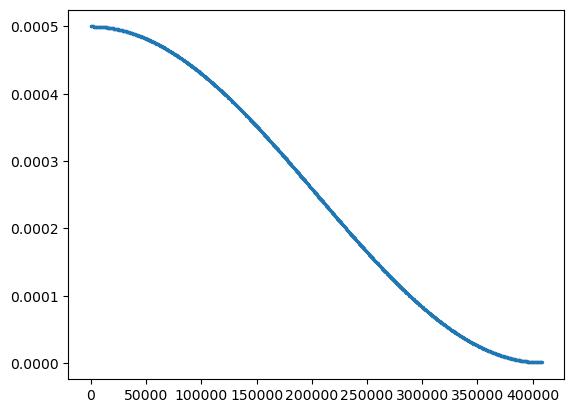


---------fold2---------
train:74752 valid:18432

288 18432
Epoch 1/350


2023-05-29 22:42:52.061267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [146]
	 [[{{node Placeholder/_0}}]]
2023-05-29 22:42:52.061656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [146]
	 [[{{node Placeholder/_0}}]]


KeyboardInterrupt: 

In [33]:
CFG.output_dir = ''

# train_folds(CFG, [0])
#train_folds(CFG, [1])
train_folds(CFG, [2])
train_folds(CFG, [3])
train_folds(CFG, [4])

In [ ]:
# fold1 => 150/150 - 77s - loss: 2.0847 - categorical_accuracy: 0.6793 - val_loss: 2.0803 - val_categorical_accuracy: 0.6991 - 77s/epoch - 512ms/step
# fold0 => 136/136 - 76s - loss: 2.1338 - categorical_accuracy: 0.6692 - val_loss: 1.6775 - val_categorical_accuracy: 0.7987
# fold4 => 145/145 - 71s - loss: 2.1799 - categorical_accuracy: 0.6559 - val_loss: 1.7580 - val_categorical_accuracy: 0.7841 - 71s/epoch - 492ms/step
# fold2 => 292/292 - 75s - loss: 1.8099 - categorical_accuracy: 0.8042 - val_loss: 1.8336 - val_categorical_accuracy: 0.7546 -
# fold3 => 302/302 - 75s - loss: 1.8459 - categorical_accuracy: 0.7937 - val_loss: 1.8191 - val_categorical_accuracy: 0.7494 - 75s/epoch - 248ms/step

In [ ]:
# CFG.seed = 42
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)

In [ ]:
# CFG.seed = 43
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)

In [ ]:
# CFG.seed = 44
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)

In [ ]:
# CFG.seed = 45
# CFG.comment = f'islr-fp16-192-8-seed{CFG.seed}'
# train_folds(CFG, ['all'], summary=False)

### Operations applied after metric reached its peak

In [ ]:
CFG.awp = False
awp_start_epoch = 1000
dropout_start_epoch = 1000
CFG.weight_decay = 0.0
CFG.lr = 1725e-7#1725e-6
CFG.lr_min = 1725e-8
CFG.resume = 1
CFG.loc = '/kaggle/input/islr-weights/weights'
CFG.batch_size = 256

train_folds(CFG, [4])



<_PrefetchDataset element_spec=(TensorSpec(shape=(256, 384, 708), dtype=tf.float32, name=None), TensorSpec(shape=(256, 250), dtype=tf.float32, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 708), dtype=tf.float32, name=None), TensorSpec(shape=(None, 250), dtype=tf.float32, name=None))>


---------fold4---------
train:74240 valid:18944

resume from epoch1
Epoch 1/349
290/290 - 390s - loss: 3.2344 - categorical_accuracy: 0.4509 - val_loss: 2.1118 - val_categorical_accuracy: 0.6713 - 390s/epoch - 1s/step
Epoch 2/349
290/290 - 83s - loss: 2.6525 - categorical_accuracy: 0.5744 - val_loss: 2.0035 - val_categorical_accuracy: 0.7180 - 83s/epoch - 287ms/step
Epoch 3/349
290/290 - 80s - loss: 2.4600 - categorical_accuracy: 0.6271 - val_loss: 1.9653 - val_categorical_accuracy: 0.7333 - 80s/epoch - 275ms/step
Epoch 4/349
290/290 - 82s - loss: 2.3530 - categorical_accuracy: 0.6540 - val_loss: 1.9389 - val_categorical_accuracy: 0.7418 - 82s/epoch - 283ms/step
Epoch 5/349